In [1]:
# Cargamos las librerías a usar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Sección nueva

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cargamos nuestras bases de datos
issues = pd.read_csv('./data/issues.csv')
prs = pd.read_csv('./data/prs.csv')
repos = pd.read_csv('./data/repos.csv')

In [4]:
# Configurando Pandas
pd.options.mode.chained_assignment = None

In [5]:
# Función para ajustar la fecha
def adjustDate(df):
    df['date'] = df['year'].astype('str') + '-' + (df['quarter'] * 3 - 2).astype('str').str.pad(2, fillchar = '0')
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
    df = df[ df.date < '2022-01-01' ]
    
    return df

In [6]:
# Ajustando fechas
issues = adjustDate(issues)
prs = adjustDate(prs)

In [7]:
# Lenguajes que usaremos
languages = ['JavaScript', 'Python', 'PHP', 'C', 'C++', 'C#', 'Java', 'Ruby', 'HTML', 'Perl', 'R', 'CSS', 'TypeScript', 'Go', 'Shell']

In [8]:
# Función para reducir las bases de datos usando nomás los lenguajes ya mencionados
def filterLanguages(df, column):
    df["verify"] = df[column].apply(lambda x: x in languages)
    df = df[ df["verify"] == True ]
    df = df.drop(['verify'], axis=1)

    return df

In [9]:
# Reducimos las bases de datos seleccionando solamente algunos lenguajes
repos = filterLanguages(repos, 'language')
prs = filterLanguages(prs, 'name')
issues = filterLanguages(issues, 'name')

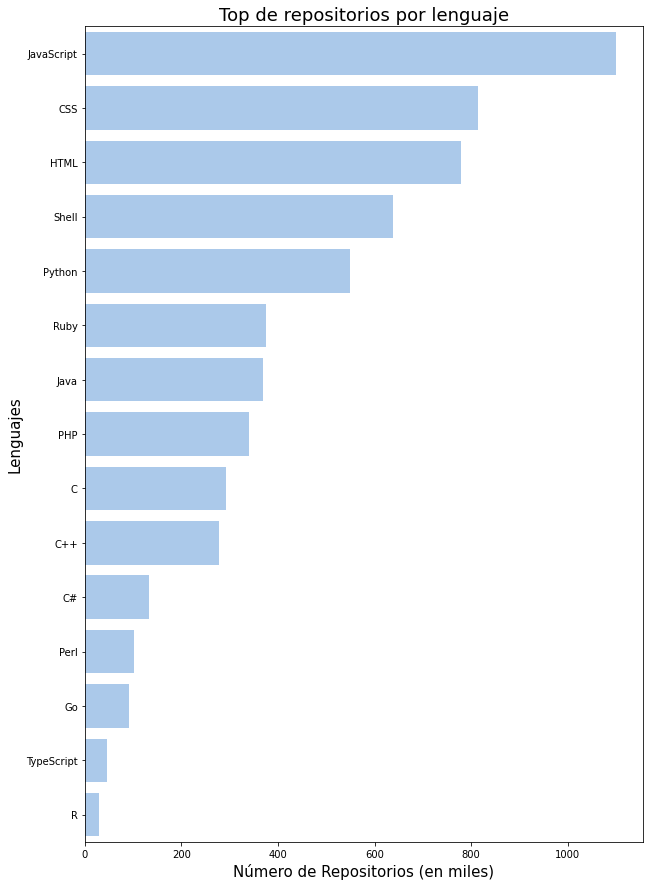

In [10]:
# Mostramos el top de repositorios
plt.figure( figsize = (10, 15) )

repos.num_repos = repos.num_repos / 1000

sns.set_color_codes("pastel")

ax = sns.barplot(
  x = "num_repos",
  y = "language",
  data = repos.iloc[:len(repos) + 1,:],
  label = "Total",
  color="b"
)
ax.axes.set_title('Top de repositorios por lenguaje', fontsize = 18)
ax.set_xlabel("Número de Repositorios (en miles)", fontsize = 15)
ax.set_ylabel("Lenguajes", fontsize = 15)

plt.show()

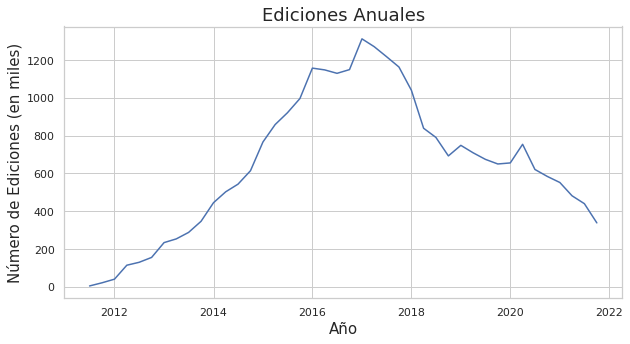

In [11]:
# Graficamos el total de ediciones por año
total_by_date = issues.groupby(['date']).sum() / 1000

plt.figure( figsize = (10, 5) )
sns.set_theme( style = 'whitegrid' )

ax = sns.lineplot(
  x = 'date',
  y = 'count',
  data = total_by_date
)
ax.axes.set_title('Ediciones Anuales', fontsize = 18)
ax.set_xlabel("Año", fontsize = 15)
ax.set_ylabel("Número de Ediciones (en miles)", fontsize = 15)

plt.show()

In [12]:
top = 5
name_list = issues.groupby(['name']).sum().sort_values('count', ascending = False)['count'][:top].index

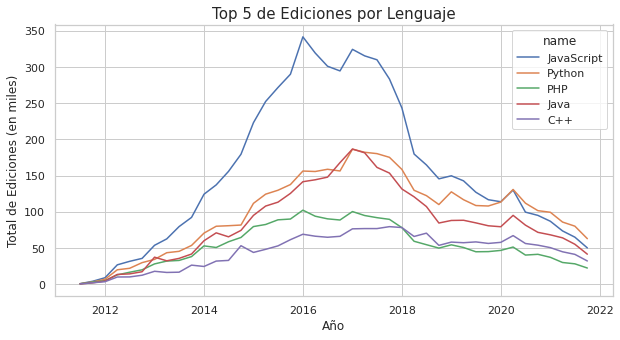

In [13]:
# Graficamos el Top 5 de Ediciones
top_issues = issues[ issues.name.isin(name_list) ]
top_issues['count'] = top_issues['count'] / 1000

plt.figure( figsize = (10, 5) )
sns.set_theme( style = 'whitegrid' )

ax = sns.lineplot(
  x = 'date',
  y = 'count',
  hue = 'name',
  data = top_issues,
)
ax.axes.set_title(f'Top {top} de Ediciones por Lenguaje', fontsize = 15)
ax.set_xlabel("Año", fontsize = 12)
ax.set_ylabel("Total de Ediciones (en miles)", fontsize = 12)

plt.show()

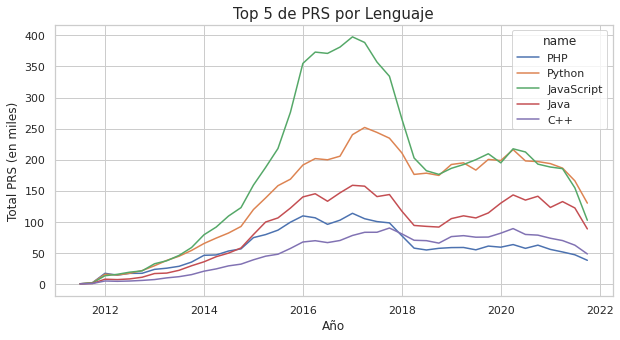

In [14]:
# Graficamos el Top 5 de PRS
top_prs = prs[ prs.name.isin(name_list) ]
top_prs['count'] = top_prs['count'] / 1000

plt.figure( figsize = (10, 5) )
sns.set_theme( style = 'whitegrid' )

ax = sns.lineplot(
  x = 'date',
  y = 'count',
  hue = 'name',
  data = top_prs
)
ax.axes.set_title(f'Top {top} de PRS por Lenguaje', fontsize = 15)
ax.set_xlabel("Año", fontsize = 12)
ax.set_ylabel("Total PRS (en miles)", fontsize = 12)

plt.show()

In [15]:
# Regresión Lineal
searchedLanguage = "Python" # Elegir cualquier lenguaje de la lista name_list

In [16]:
# Función para filtrar los datos por leguaje
def filterPerLenguage(df, lang):
    df["index"] = df["year"]
    df = df[ df["name"] == lang ].groupby(["index"]).sum()
    df = df [ df["quarter"] == 10 ]
    df["year"] /= 4
    df['year'] = df['year'].astype('int')
    df = df.drop(["quarter"], axis=1)
    return df

In [17]:
data_model = filterPerLenguage(issues, searchedLanguage)

In [18]:
# Función para el modelo lineal
def linearModel(data):
    model = smf.ols(formula = "count ~ year", data = data).fit()
    return model

In [19]:
# Resumen del modelo lineal
linear_model = linearModel(data_model)
linear_model.summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     2.317
Date:                Mon, 24 Jan 2022   Prob (F-statistic):              0.166
Time:                        02:19:32   Log-Likelihood:                -134.33
No. Observations:                  10   AIC:                             272.7
Df Residuals:                       8   BIC:                             273.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.192e+07    4.1e+07     -1.512      0.169   -1.56e+08    3.25e+07
year        3.091e+04   2.03e+04      1.522      0.166   -1.59e+04    7.77e+04
==============================================================================
Omnibus:                        0.686   Durbin-Watson:                   0.529
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.619
Skew:                           0.328   Prob(JB):                        0.734
Kurtosis:                       1.973   Cond. No.                     1.42e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

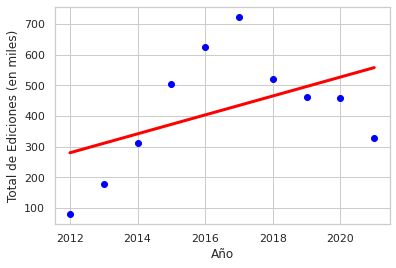

In [20]:
# Predicción del modelo
prediction_model = linear_model.predict(pd.DataFrame(data_model['year']))
prediction_model

plt.plot(data_model["year"], data_model["count"] / 1000, "o", color = "blue")
plt.plot(pd.DataFrame(data_model["year"]), prediction_model / 1000, c = "red", linewidth = 3)
plt.xlabel("Año")
plt.ylabel("Total de Ediciones (en miles)")
plt.show()